<a href="https://colab.research.google.com/github/pnnowak/Projektyrynkifin/blob/main/Modelowanieakcji_lstm_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelowanie akcji SP500 za pomocą modelu Lstm

Eksprolacja wyników i danych, sprawdzanie co poprawi wyniki modelu, badanie i próbowanie różnych podejść i różnych modeli

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt
from sklearn.metrics import mean_squared_error

In [2]:
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-01-01')

/tmp/ipython-input-2-2412655462.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


## Przygotowanie danych

In [3]:
# Dodanie prostych średnich kroczących (SMA)
sp500['SMA_10'] = sp500['Close'].rolling(window=20).mean()

# Dodanie wykładniczych średnich kroczących (EMA) - często uważane za bardziej responsywne
sp500['EMA_10'] = sp500['Close'].ewm(span=20, adjust=False).mean()

sp500 = sp500.dropna()

# display(sp500_with_indicators.head())

In [4]:
def prepare_data(sp500):
  sp500.reset_index(inplace=True)
  close_prices = sp500['Close'].values.reshape(-1, 1)
  Sma_prices = sp500['SMA_10'].values.reshape(-1, 1)
  Ema_prices = sp500['EMA_10'].values.reshape(-1, 1)
  combined_features = np.hstack((close_prices, Sma_prices, Ema_prices))
  scaler = MinMaxScaler() # od 0 do 1
  values_scaled = scaler.fit_transform(combined_features)
  return values_scaled, scaler

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Bierzemy wszystkie kolumny cech dla okna czasowego
        X.append(data[i:i+seq_length, :])
        # Przewidujemy tylko cenę zamknięcia (pierwsza kolumna w naszym przypadku)
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

def split_data(X, y):
  split = int(len(X) * 0.8)
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  return X_train, X_test, y_train, y_test

In [5]:
values_scale, scaler = prepare_data(sp500)
dni_predycji = 60
X, y = create_sequences(values_scale, dni_predycji)
X_train, X_test, y_train, y_test = split_data(X, y)

In [6]:
# musimy je również umieścić w tymczasowej tablicy o 3 kolumnach.
num_features = scaler.n_features_in_
temp_y_test = np.zeros((len(y_test), num_features))
temp_y_test[:, 0] = y_test

inverted_y_test = scaler.inverse_transform(temp_y_test)
y_test_original_scale = inverted_y_test[:, 0].reshape(-1, 1)

y_test = y_test_original_scale

## Prosty Model

In [24]:
model = Sequential([
    LSTM(50, input_shape=(60, 3), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(X_train, y_train, epochs=50, batch_size=60)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.5503e-05
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.4566e-05
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.4650e-05
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4854e-05
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.4177e-05
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.5909e-05
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.3980e-05
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3054e-05
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.4565e-05
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.3949e-05
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.3185e-05
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.3511e-05
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.3892e-05
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.7108e-05
Epoch 15/50
83/

In [37]:
predictions = model.predict(X_test)

num_features = scaler.n_features_in_
temp_array = np.zeros((len(predictions), num_features))
temp_array[:, 0] = predictions[:, 0] # Umieść predykcje ceny zamknięcia w pierwszej kolumnie

inverted_predictions = scaler.inverse_transform(temp_array)

predictions = inverted_predictions[:, 0].reshape(-1, 1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [38]:
print(predictions[:5])
print(y_test[:5])

[[3288.75001647]
 [3241.33272486]
 [3258.45885808]
 [3263.4986989 ]
 [3272.3128137 ]]
[[3243.62988281]
 [3276.23999023]
 [3273.39990234]
 [3283.65991211]
 [3225.52001953]]


In [39]:
# Obliczenie MSE
mse = mean_squared_error(y_test, predictions)
print(f"Błąd średniokwadratowy (MSE): {mse:.2e}")

Błąd średniokwadratowy (MSE): 3.28e+03


batch 32: Błąd średniokwadratowy (MSE): 3.12e+03

batch 60: Błąd średniokwadratowy (MSE): 4.26e+03

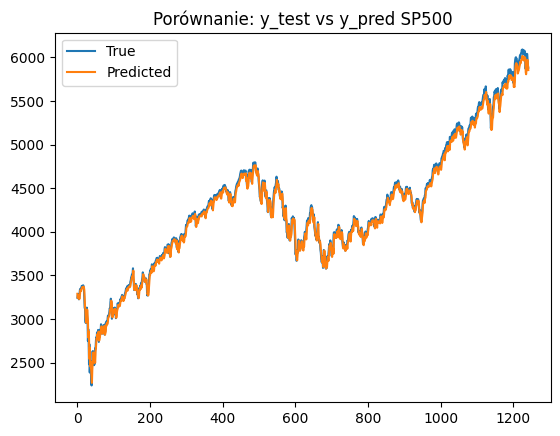

In [40]:
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

## Bardziej zaawansowany model

In [30]:
#drugi model trochę większy
model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 3)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,251 (200.20 KB)

 Trainable params: 51,251 (200.20 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history1 = model1.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 0.0046
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 4.1239e-04
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 3.4681e-04
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 4.1129e-04
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 3.2030e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 2.9688e-04
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 2.4556e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 2.3287e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 2.1651e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 1.9385e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 1.8189e-04
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 1.7147e-04
Epoch 13/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 1.7737e-04
Epoch 14/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/s

In [32]:
predictions1 = model1.predict(X_test)

num_features1 = scaler.n_features_in_
temp_array1 = np.zeros((len(predictions1), num_features1))
temp_array1[:, 0] = predictions1[:, 0] # Umieść predykcje ceny zamknięcia w pierwszej kolumnie

inverted_predictions1 = scaler.inverse_transform(temp_array1)

predictions1 = inverted_predictions1[:, 0].reshape(-1, 1)

print("Przykładowe predykcje po odwróceniu skalowania:", predictions1[:5])

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Przykładowe predykcje po odwróceniu skalowania: [[3304.94617426]
 [3305.24756116]
 [3301.8461486 ]
 [3296.16626397]
 [3290.06882618]]


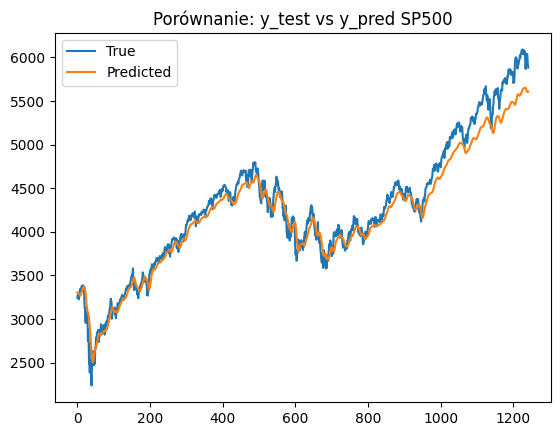

In [33]:
plt.plot(y_test, label='True')
plt.plot(predictions1, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

In [34]:
# Obliczenie MSE
mse1 = mean_squared_error(y_test, predictions1)
print(f"Błąd średniokwadratowy (MSE): {mse1:.2e}")

Błąd średniokwadratowy (MSE): 2.65e+04


## Porównanie z bardzo prostymi modelami

In [ ]:
baseline_predictions = np.full_like(y_test, np.mean(y_train))

# Obliczenie błędu średniokwadratowego (MSE) dla modelu referencyjnego
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {baseline_mse:.2e}")

Błąd średniokwadratowy modelu referencyjnego (MSE): 1.88e+07


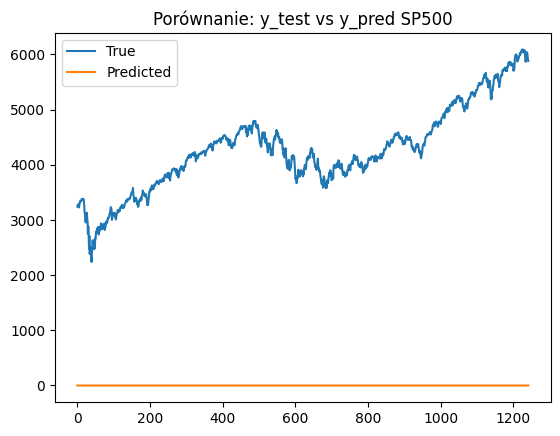

In [ ]:
plt.plot(y_test, label='True')
plt.plot(baseline_predictions, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

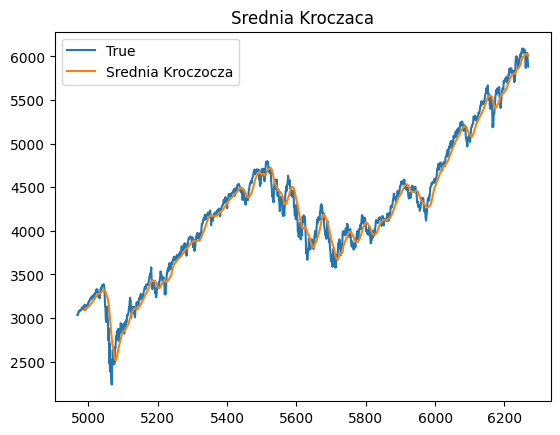

Błąd średniokwadratowy modelu referencyjnego (MSE): 1.26e+04


In [ ]:
# Tworzymy nowy DataFrame do obliczeń średniej kroczącej
sp5001 = pd.DataFrame()
split = int(len(y) * 0.8)  # Podział na zbiór treningowy i testowy
sp5001['Test'] = sp500["Close"][split:]  # Dane treningowe (pierwsze 80%)

# Obliczanie średniej kroczącej (SMA) z 16 dni
window_size = 20
sp5001['SMA'] = sp5001['Test'].rolling(window=window_size).mean()

plt.plot(sp5001['Test'], label='True')
plt.plot(sp5001['SMA'] , label='Srednia Kroczocza')
plt.title("Srednia Kroczaca")
plt.legend()
plt.show()

# Usunięcie wierszy z NaN przed obliczeniem MSE
sp5001_cleaned = sp5001.dropna()

srednia_kroczaca = mean_squared_error(sp5001_cleaned['Test'], sp5001_cleaned['SMA'])
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {srednia_kroczaca:.2e}")

### Zapisywanie, wczytywanie i wyświetlanie wykresów pierwszego Modelu.




In [ ]:
from google.colab import drive
from google.colab import files

# Zapisz model lokalnie w katalogu Colab
model.save('lstm_model.keras')
files.download('lstm_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lstm_model.keras to lstm_model.keras


In [ ]:
# Wczytanie modelu z Google Drive
from tensorflow.keras.models import load_model
model = load_model("lstm_model.keras")

# Sprawdzenie struktury modelu
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
history.history.keys()

dict_keys(['loss'])

## Porównujemy wyniku z obu modeli

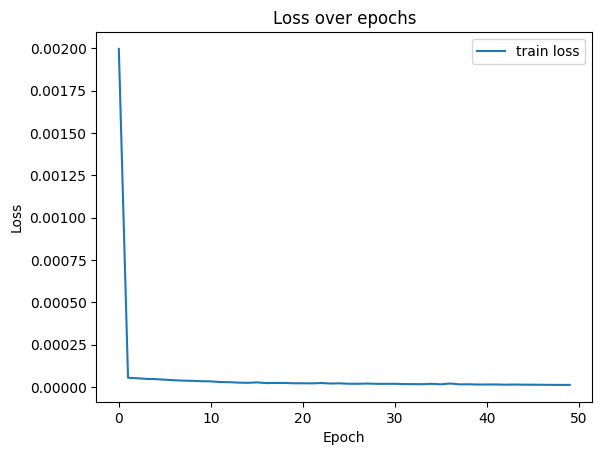

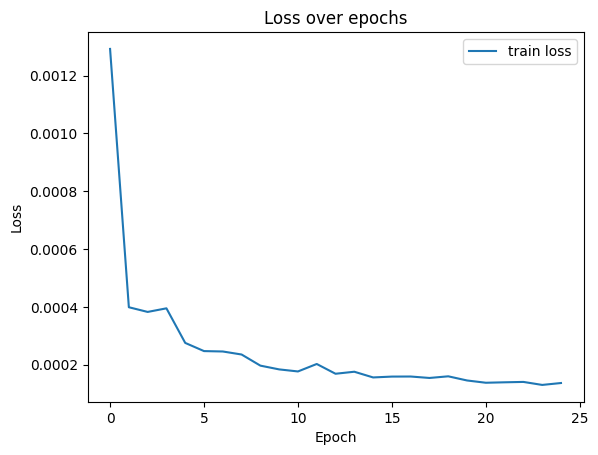

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

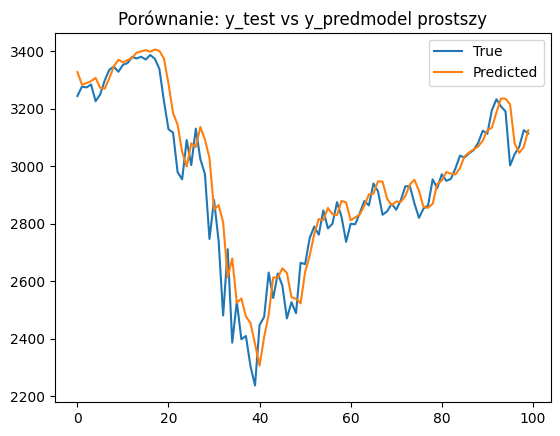

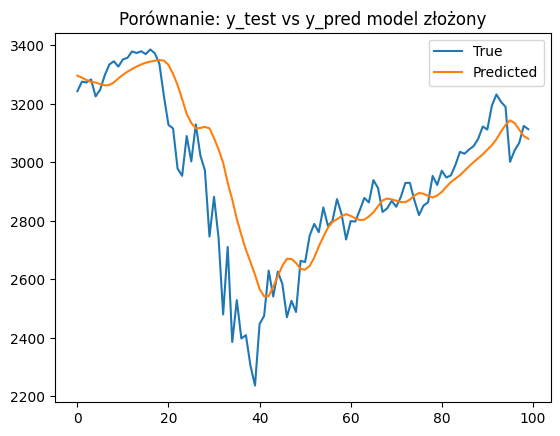

In [ ]:
plt.plot(y_test[:100], label='True')
plt.plot(predictions[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_predmodel prostszy")
plt.legend()
plt.show()

plt.plot(y_test[:100], label='True')
plt.plot(predictions1[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred model złożony")
plt.legend()
plt.show()

### Mamy gorsze wyniki modelu złożonego, po zwiększeniu z 25 epok do 50 modelu złożomego i dodaniu do obu dodatkowych wzkażników wyniki się lekko pogarszają, 50 epok lekko przeucza model, więc zmieniam na 25, a dodanie doatkowych cech nie pomaga, a wręcz przeszkadza. Ale narazie zostawię te wzkażniki i spróbuję dodać regularyzaje i sprawdzę inne wzkażniki niż mse.

## Model złożony z regularyzacja (dziwne wyniki)

In [ ]:
from tensorflow.keras.regularizers import l2

# Ustawienia modelu
lstm_units = 50
dropout_rate = 0.2
l2_lambda = 0.001

model_complex_regularized = Sequential()

model_complex_regularized.add(LSTM(units=lstm_units, return_sequences=True,
                                   input_shape=(dni_predycji, 3),
                                   kernel_regularizer=l2(l2_lambda),
                                   recurrent_regularizer=l2(l2_lambda)))
model_complex_regularized.add(Dropout(dropout_rate))

model_complex_regularized.add(LSTM(units=lstm_units, return_sequences=True,
                                   kernel_regularizer=l2(l2_lambda),
                                   recurrent_regularizer=l2(l2_lambda)))

model_complex_regularized.add(Dropout(dropout_rate))

model_complex_regularized.add(LSTM(units=lstm_units,
                                   kernel_regularizer=l2(l2_lambda),
                                   recurrent_regularizer=l2(l2_lambda)))

model_complex_regularized.add(Dropout(dropout_rate))

model_complex_regularized.add(Dense(units=1))


model_complex_regularized.compile(optimizer='adam', loss='mse')

model_complex_regularized.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,251 (200.20 KB)

 Trainable params: 51,251 (200.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history4 = model1.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 1.4332e-04
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 1.3234e-04
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 1.1336e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 1.2086e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 1.3439e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 1.0996e-04
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 1.1019e-04
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 1.1866e-04
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 1.1410e-04
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 1.2412e-04


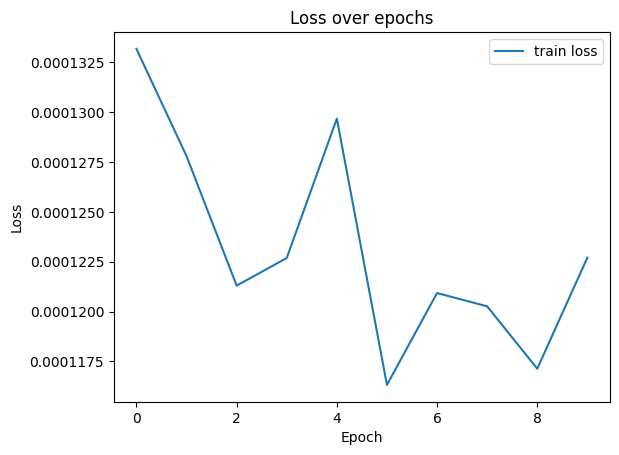

In [ ]:
plt.plot(history4.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions4 = model_complex_regularized.predict(X_test)

num_features4 = scaler.n_features_in_
temp_array4 = np.zeros((len(predictions4), num_features4))
temp_array4[:, 0] = predictions4[:, 0] # Umieść predykcje ceny zamknięcia w pierwszej kolumnie

inverted_predictions4 = scaler.inverse_transform(temp_array4)

predictions4 = inverted_predictions4[:, 0].reshape(-1, 1)

print("Przykładowe predykcje po odwróceniu skalowania:", predictions4[:5])

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Przykładowe predykcje po odwróceniu skalowania: [[834.8815088 ]
 [835.1257302 ]
 [835.39509071]
 [835.68383243]
 [835.98292021]]


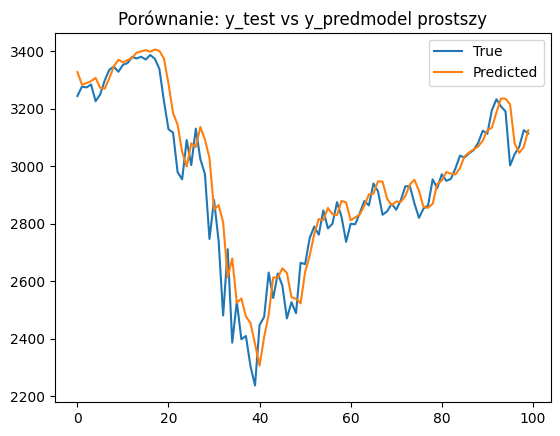

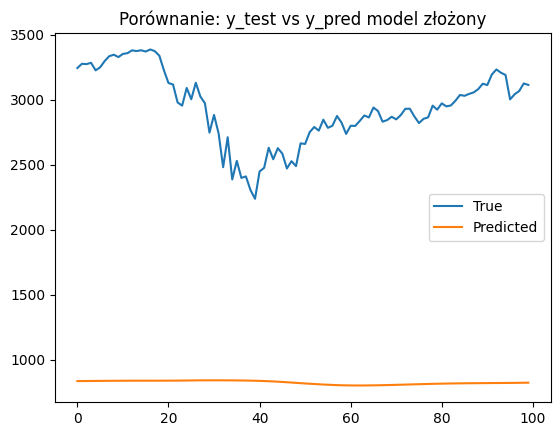

In [ ]:
plt.plot(y_test[:100], label='True')
plt.plot(predictions[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_predmodel prostszy")
plt.legend()
plt.show()

plt.plot(y_test[:100], label='True')
plt.plot(predictions4[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred model złożony")
plt.legend()
plt.show()

Przykładowe predykcje po odwróceniu skalowania: [[834.8815088 ]
 [835.1257302 ]
 [835.39509071]
 [835.68383243]
 [835.98292021]] dziwne wyniki dla 25 epok dla 10 też dziwne

Prostszy Model ma lepsze wyniki niż zaawansowany, z tego co próbowałem dla naszych akcji sp500. Z powyższego powodu sprobuję stworzyć model średnio zaawansowany oraz jeszcze prostrzy model, może nie trzeba używać lstm?

## Model średnio złożony

In [13]:
#drugi model trochę większy
modelzl = Sequential()

modelzl.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 3)))
modelzl.add(Dropout(0.2))
modelzl.add(LSTM(units=50))
modelzl.add(Dropout(0.2))
modelzl.add(Dense(units=1))

modelzl.compile(optimizer='adam', loss='mse')
modelzl.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
historyzl = modelzl.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0037
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 3.6119e-04
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.3708e-04
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 2.8855e-04
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 2.6343e-04
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2.2514e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 2.1648e-04
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 1.9168e-04
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 2.0196e-04
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 1.5621e-04
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 1.4893e-04
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 1.6061e-04
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 1.4333e-04
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step

In [15]:
predictionszl = modelzl.predict(X_test)

num_featureszl = scaler.n_features_in_
temp_arrayzl = np.zeros((len(predictionszl), num_featureszl))
temp_arrayzl[:, 0] = predictionszl[:, 0] # Umieść predykcje ceny zamknięcia w pierwszej kolumnie

inverted_predictionszl = scaler.inverse_transform(temp_arrayzl)

predictionszl = inverted_predictionszl[:, 0].reshape(-1, 1)

print("Przykładowe predykcje po odwróceniu skalowania:", predictionszl[:5])

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Przykładowe predykcje po odwróceniu skalowania: [[3312.56345392]
 [3297.38504162]
 [3287.20242377]
 [3281.44380423]
 [3281.17178158]]


In [16]:
baseline_mse_blad = mean_squared_error(y_test, predictionszl)
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {baseline_mse_blad:.2e}")

Błąd średniokwadratowy modelu referencyjnego (MSE): 1.02e+04


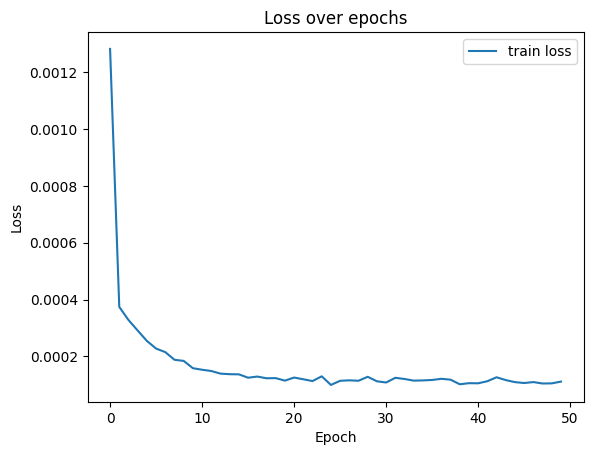

In [17]:
plt.plot(historyzl.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

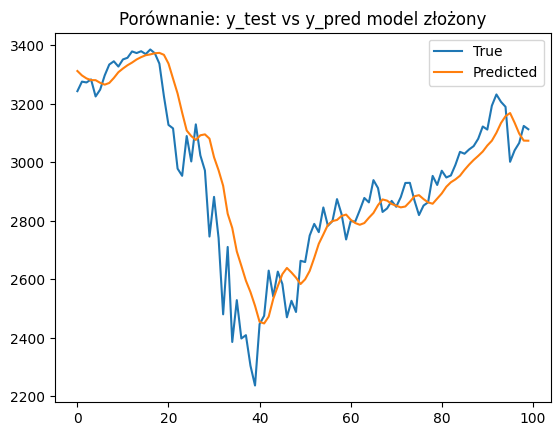

In [18]:
plt.plot(y_test[:100], label='True')
plt.plot(predictionszl[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred model złożony")
plt.legend()
plt.show()

## Wyniki i dalsza analiza

Prosty Model:

batch 32: Błąd średniokwadratowy (MSE): 3.12e+03

batch 60: Błąd średniokwadratowy (MSE): 4.26e+03

SredniModel:

epoki 25: Błąd średniokwadratowy modelu referencyjnego (MSE): 1.40e+04

epoki 50: Błąd średniokwadratowy modelu referencyjnego (MSE): 1.02e+04

Najbardziej zaawansowany:

Błąd średniokwadratowy (MSE): 1.01e+05

Im bardziej złożony model tym gorszee wyniki?

Teraz spróbuje porównać który model lepiej oddaje trend i jak dobrze to robią, sprawdzę to za pomocą współczynnika hursta.

In [20]:
!pip install hurst

In [21]:
from hurst import compute_Hc
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def obliczanie_husrat(ts, dla):
  # Obliczenie współczynnika Hurst'a
  H, c, data = compute_Hc(ts, kind='price', simplified=True)

  print(f"Współczynnik Hurst'a: {H:.4f}")

  # Interpretacja
  if H < 0.5:
      print(dla, "Proces ma tendencję do rewersji do średniej (antypersistencja): ")
  elif H > 0.5:
      print(dla, "Proces ma tendencję do kontynuowania trendu (persistencja): ")
  else:
      print(dla, "Proces jest losowy (Brownowski): ")


In [44]:
obliczanie_husrat(y_test, "y_test")
print(" ")
obliczanie_husrat(predictions, "predictions-prostymodel")
print(" ")
obliczanie_husrat(predictions1, "predictions1-skomplikoway model")
print(" ")
obliczanie_husrat(predictionszl, "predictionszl-średnioskomplikowany model")

Współczynnik Hurst'a: 0.6806
y_test Proces ma tendencję do kontynuowania trendu (persistencja): 
 
Współczynnik Hurst'a: 0.6959
predictions-prostymodel Proces ma tendencję do kontynuowania trendu (persistencja): 
 
Współczynnik Hurst'a: 0.6241
predictions1-skomplikoway model Proces ma tendencję do kontynuowania trendu (persistencja): 
 
Współczynnik Hurst'a: 0.6858
predictionszl-średnioskomplikowany model Proces ma tendencję do kontynuowania trendu (persistencja): 


Prosty i średni model najbliżej oddają trend.

## Wnioski

Prosty model:

Tak dobre wyniki są trochę dla mnie podejrzane, trochę to wygląda jakby model korzystał mocno z X, wykresy predykcji faktycznych wyników wyglądają podejrzanie podobnie. Model dobrze oddaje trend, predykcje mają niższy błąd średniokwadrowy niż np. średniakrocząca, na szczęście.
Duża szansa, że daje za dużo informacji w X.

Sredni model:

Dobre wyniki, najlepiej odwzorowuje trend, jednak tylko trochę lepiej niż model prosty, jednocześnie wykresy porównawcze predykcji i danych testowych nie wyglądają podejrzanie podobne, prawdopodobnie wykorzystywałbym ten model, tą architekturę przynajmiej.

Złożony:

Słabo, może danie mu więcej epok by pomogło, ale wymaga to długiego trenowania, z niepewnymi efektami, a może i tak by performował gorzej wyższym kosztem.


Modele te w praktyce są oczywiście nieużytkowe, bo normalnie nie mamy takich zaawansowanych informacji o przyszłości, nie wiemy jakie będą wtedy średnie kroczące, ani nic w tym rodzaju.

In [52]:
def predykcja_2(model):

  predict = model.predict(X_test[0:1])

  num_features = scaler.n_features_in_
  temp_arrayhg = np.zeros((len(predict), num_features))
  temp_arrayhg[:, 0] = predict[:, 0] # Umieść predykcje ceny zamknięcia w pierwszej kolumnie

  inverted_predict = scaler.inverse_transform(temp_arrayhg)

  predict = inverted_predict[:, 0].reshape(-1, 1)
  return predict

In [53]:
predictsrednio = predykcja_2(modelzl)
print(predictsrednio)
predictprosty = predykcja_2(model)
print(predictprosty)
print(y_test[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[3312.56345392]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[3288.75033915]]
[[3243.62988281]]


Natomiast, gdyby urealinić model i skorzystać dodatkowo np, z modelu Arima, ma on pewien potencjał.